In [47]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import esmlab

import intake
import intake_esm
import ncar_jobqueue
from dask.distributed import Client
from pint import UnitRegistry

units = UnitRegistry()
units.define('gram N = mol / 14.007 = gN')


import utils
#%load_ext watermark
#%watermark -a "Mike Levy" -d -iv -m -g -h

In [48]:
try:
    cluster
    client
except: 
    cluster = ncar_jobqueue.NCARCluster(project='NCGD0011')
    cluster.scale(16) #adapt(minimum_jobs=0, maximum_jobs=24)
    client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.25:42343 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 16 Cores: 16 Memory: 400.00 GB


In [49]:
def _read_var(dq, time_slice, variable):
    # Define datasets
    dataset = dq['ocn.historical.pop.h']

    keep_vars = ['REGION_MASK', 'z_t', 'z_t_150m', 'dz', 'TAREA', 'TLONG', 'TLAT', 'time', 'time_bound', 'member_id', 'ctrl_member_id'] + [variable]
    with xr.set_options(keep_attrs=True):
        dataset = dataset.drop([v for v in dataset.variables if v not in keep_vars]).sel(time=time_slice).mean(dim=['member_id', 'time'])

    return(dataset)

In [50]:
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')

datasets = dict()
for variable in ['diaz_Nfix', 'DENITRIF']:
    dq = catalog.search(experiment='historical', variable=variable).to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
    datasets[variable] = _read_var(dq, slice("1990-01-15", "2000-01-15"), variable)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
             
--> There are 1 group(s)
Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'
             
--> There are 1 group(s)


In [51]:
area_units = units[datasets['diaz_Nfix']['TAREA'].attrs['units']]
vert_units = units[datasets['diaz_Nfix']['dz'].attrs['units']]
vol_units = area_units * vert_units
N_units = dict()
for var in ['diaz_Nfix', 'DENITRIF']:
    N_units[var] = units[datasets[var][var].attrs['units']]

total_integral_units = 'TgN/year'
plot_units = 'mmol/m^2/year'

### Vertical integrals first (for plotting)

In [52]:
vwghts = dict()
vdim = dict()
vwghts['diaz_Nfix'] = datasets['diaz_Nfix']['dz'].isel(z_t=slice(0,15)).rename({'z_t' : 'z_t_150m'})
vdim['diaz_Nfix'] = 'z_t_150m'
vwghts['DENITRIF'] = datasets['DENITRIF']['dz']
vdim['DENITRIF'] = 'z_t'

names = dict(
    diaz_Nfix='Nitrogen fixation',
    DENITRIF='Denitrification',
)

vertical_ints = dict()
val_to_plot = dict()

vertical_ints['AREA'] = datasets['DENITRIF'].TAREA * 1e-4
vertical_ints['AREA'].attrs['units'] = 'm^2'

for var in ['diaz_Nfix', 'DENITRIF']:
    vertical_ints[var] = esmlab.weighted_sum(datasets[var][var], dim=vdim[var], weights=vwghts[var]).to_dataset(name=var)[var].compute()
    # Use below to include marginal seas
#     vertical_ints[var] = vertical_ints[var].where(datasets[var]['REGION_MASK'] != 0).compute()
    # Use below to restrict to open ocean
    vertical_ints[var] = vertical_ints[var].where(datasets[var]['REGION_MASK']>0).compute()
    vertical_ints[var].data = ((vertical_ints[var].data * N_units[var] * vert_units).to(plot_units)).magnitude
    vertical_ints[var].attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'
    vertical_ints[var].attrs['long_name'] = names[var]

In [53]:
for var in ['diaz_Nfix', 'DENITRIF']:
    attrs = vertical_ints[var].attrs
    global_integral = (vertical_ints[var] * vertical_ints['AREA']).sum().values * 14. * 1e-12 * 1e-3
    title_str = f"{attrs['long_name']} ({global_integral:0.1f} Tg N " + 'yr$^{-1}$)'    
    print(title_str)
    vertical_ints[var].attrs['title_str'] = title_str
    

Nitrogen fixation (241.2 Tg N yr$^{-1}$)
Denitrification (193.1 Tg N yr$^{-1}$)


In [54]:
ds = xr.Dataset(vertical_ints)
ds

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320)
Coordinates:
    TLONG      (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT       (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    AREA       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    diaz_Nfix  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    DENITRIF   (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

In [55]:
dso_map = {
    'data/Ncycle.zarr': ds, 
}
for file_out, dso in dso_map.items():
    utils.write_ds_out(dso, file_out)

------------------------------
Writing /glade/u/home/mclong/p/cesm2-marbl/notebooks/data/Ncycle.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;

variables:
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float64 AREA(nlat, nlon) ;
		AREA:units = m^2 ;
	float32 diaz_Nfix(nlat, nlon) ;
		diaz_Nfix:units = mmol m$^{-2}$ yr$^{-1}$ ;
		diaz_Nfix:long_name = Nitrogen fixation ;
		diaz_Nfix:title_str = Nitrogen fixation (241.2 Tg N yr$^{-1}$) ;
	float32 DENITRIF(nlat, nlon) ;
		DENITRIF:units = mmol m$^{-2}$ yr$^{-1}$ ;
		DENITRIF:long_name = Denitrification ;
		DENITRIF:title_str = Denitrification (193.1 Tg N yr$^{-1}$) ;

// global attributes:
}


### Then horizontal integral to get total value for caption

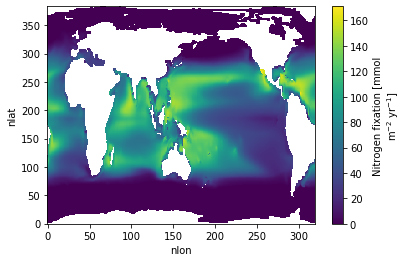

In [56]:
ds.diaz_Nfix.plot()

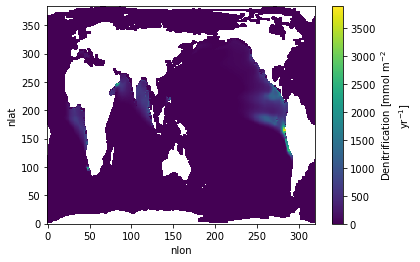

In [57]:
ds.DENITRIF.plot()